
### Aims
> 1. Image classification using DNN and CNN 
> 2. Use of RNN to predict texts for image captioning 


### Objectives

> 1. Implement  deep neural network and convolutional neural network (CNN) and see how these can 
     be used for classification problem 
> 2. Building, evaluating, and finetuning  CNN on an image dataset from development to testing stage. 
> 3. Tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Use RNNs to predict the caption of an image from established word vocabularies
> 5. Understand and visualise text predictions for a given image.



### Part I: Image Classification 

#### Dataset
This project will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). 


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks


In [2]:
import cv2
import math
from tqdm.notebook import trange, tqdm
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
import time
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# always check your version
print(torch.__version__)

2.2.1


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the project involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation** 

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes 
*   **1.2** PyTorch ```Model``` class for a simple MLP model 
*   **1.3** PyTorch ```Model``` class for a simple CNN model 

**2. Model training** 
*   **2.1** Training on TinyImageNet30 dataset 
*   **2.2** Generating confusion matrices and ROC curves 
*   **2.3** Strategies for tackling overfitting 
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** 
*   **3**   Testing  final model in (2) on test set - code to do this 


**4. Model Fine-tuning on CIFAR10 dataset** 
*   **4.1** Fine-tuning model (initialise your model with pretrained weights from (2)) 
*   **4.2** Fine-tuning model with frozen base convolution layers
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. 


<!-- **5. Model comparison**
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time)
<!-- 
**6. Interpretation of results** 
*   **6.1** Implement grad-CAM for the model and AlexNet 
*   **6.2** Visualise and compare the results from the model and AlexNet 

**7. Residual connection for deeper network**
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. 


## 1 Function implementations


### 1.1 Dataset class 

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [3]:
!pip install natsort

In [3]:
import os
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
from torchvision import datasets, transforms

#transforms to convert raw data to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])


'''train_transform = transforms.Compose([
                            transforms.Resize((64, 64)),  
                            transforms.ToTensor(),       
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2)])'''



# Create datasets
train_data = ImageFolder(root="./train_set", transform=transform)

# Create DataLoaders 
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)






### 1.2 Define a MLP model class 

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [65]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.input_fc = nn.Linear(input_dim, 900)
    
        self.hidden_fc1 = nn.Linear(900, 350)
        self.hidden_fc2=nn.Linear(350,100)
   
        self.output_fc = nn.Linear(100, output_dim)
         
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        #x = self.flatten(x)
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))

        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))

        y_pred = self.output_fc(h_3)
        return y_pred, h_3

ip_dim = 64 * 64 *3
op_dim = 30

model = MLP(ip_dim, op_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [7]:
#for param in model.parameters():
   # print(param)

### 1.3 Define a CNN model class

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [5]:
# Model class of CNN

import torch.optim as optim

class TinyImageCNN(nn.Module):
    def __init__(self):
        super(TinyImageCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm1= nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.batch_norm2= nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm3= nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm4= nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm5= nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm6= nn.BatchNorm2d(512)
        
        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512*2*2 , 1000)  # Adjusted for 64x64 input image size
        self.fc2 = nn.Linear(1000, 30) 

    def forward(self, x):
        # Convolutional layers with ReLU activation and max-pooling
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool(F.relu(self.batch_norm5(self.conv5(x))))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        
        #Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
      
        x = self.fc2(x)
        return x
        
model_cnn = TinyImageCNN()

#loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.01)

## 2 Model training


### 2.1 Train both MLP and CNN model 

Train the model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. 


In [6]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [7]:

#creating validation data set
import copy
from torch.utils.data.dataset import random_split
torch.manual_seed(0)
total_size = len(train_data)
val_size = int(0.2 * total_size)
train_size = total_size - val_size
train_dataset, valid_dataset = random_split(train_data, [train_size, val_size])

# applying test transform to validation data. First making a deep copy of validation data to avoid transformation of training data
val_dataset = copy.deepcopy(valid_dataset)
val_dataset.dataset.transform = transform

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)





In [7]:
num_train_samples = len(train_dataset)
print("Number of elements in the training dataset:", num_train_samples)

Number of elements in the training dataset: 10800


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#One epoch time calculation
def epoch_time(start, end):
    elapsed_time = end - start
    elapsed_mins = int(elapsed_time / 60)
    elapsed_seconds = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_seconds


In [10]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
            return True


In [66]:

#MLP
# Finding training accuracy and loss by putting the model in training mode.
import time
epochs= 50
best_val_loss = float('inf')
epoch_n=[]
train_a=[]
val_a=[]
train_l=[]
val_l=[]

for epoch in trange(epochs):
    
    start = time.monotonic()
    epoch_loss1 = 0
    epoch_acc1 = 0
    epoch_loss2 = 0
    epoch_acc2 = 0
    
    model.train()
    for batch_num, batch_data in enumerate(train_loader, 0):
        x1, y1 = batch_data
        x1 = x1.to(device)
        y1 = y1.to(device)

        optimizer.zero_grad() # Clear the gradients

        y_pred1, _ = model(x1)
        loss1 = criterion(y_pred1, y1) #Finding loss
        acc1 = topk_accuracy(y_pred1, y1) #finding accuarcy
        loss1.backward()  #calcukating gradients
        optimizer.step() #Updating weights

        epoch_loss1 += loss1.item()
        accuracy1 = torch.tensor(acc1)
        epoch_acc1 += accuracy1.item()
    train_loss, train_acc = epoch_loss1 / len(train_loader), epoch_acc1 / len(train_loader)

#Finding validation acuuracy and loss by putting the model in evaluating mode

    model.eval()
    with torch.no_grad():

        for  batch_num, batch_data in enumerate(val_loader, 0):
            x2, y2 = batch_data
            x2 = x2.to(device)
            y2 = y2.to(device)

            y_pred2, _ = model(x2)

            loss2 = criterion(y_pred2, y2)

            acc2 = topk_accuracy(y_pred2, y2)

            epoch_loss2 += loss2.item()
            accuracy2 = torch.tensor(acc2)

            epoch_acc2 += accuracy2.item()

    val_loss, val_acc=epoch_loss2 / len(val_loader), epoch_acc2 / len(val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end = time.monotonic()
    
    #earlystopping
    '''if early_stopping(train_loss, val_loss, min_delta=0.01, tolerance = 30):
        print("We are at epoch:", i)
        break'''

    epoch_mins, epoch_seconds = epoch_time(start, end)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_seconds}s')
    print(f'\tTrain_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.3f}%')
    print(f'\t Val_Loss: {val_loss:.4f} |  Val_Acc: {val_acc:.3f}%')
    epoch_n.append(epoch)
    train_a.append(train_acc)
    val_a.append(val_acc)
    train_l.append(train_loss)
    val_l.append(val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 18s
	Train_Loss: 3.0849 | Train_Acc: 13.245%
	 Val_Loss: 2.9229 |  Val_Acc: 17.443%
Epoch: 02 | Epoch Time: 0m 15s
	Train_Loss: 2.7429 | Train_Acc: 21.127%
	 Val_Loss: 2.8238 |  Val_Acc: 19.692%
Epoch: 03 | Epoch Time: 0m 15s
	Train_Loss: 2.5144 | Train_Acc: 27.525%
	 Val_Loss: 2.7905 |  Val_Acc: 21.768%
Epoch: 04 | Epoch Time: 0m 15s
	Train_Loss: 2.2896 | Train_Acc: 34.006%
	 Val_Loss: 2.8619 |  Val_Acc: 21.821%
Epoch: 05 | Epoch Time: 0m 15s
	Train_Loss: 2.0659 | Train_Acc: 40.570%
	 Val_Loss: 2.9774 |  Val_Acc: 20.592%
Epoch: 06 | Epoch Time: 0m 15s
	Train_Loss: 1.7498 | Train_Acc: 49.679%
	 Val_Loss: 3.0433 |  Val_Acc: 21.503%
Epoch: 07 | Epoch Time: 0m 15s
	Train_Loss: 1.4575 | Train_Acc: 57.797%
	 Val_Loss: 3.2193 |  Val_Acc: 21.431%
Epoch: 08 | Epoch Time: 0m 15s
	Train_Loss: 1.1660 | Train_Acc: 65.997%
	 Val_Loss: 3.5248 |  Val_Acc: 21.621%
Epoch: 09 | Epoch Time: 0m 15s
	Train_Loss: 0.9369 | Train_Acc: 72.838%
	 Val_Loss: 3.8006 |  Val_Acc: 20.828%
E

In [19]:
#cnn 
epo_n=[]
trn_a=[]
vl_a=[]
trn_l=[]
vl_l=[]

#defining to use during data augmentation
epo_n_agtd=[]
trn_a_agtd=[]
vl_a_agtd=[]
trn_l_agtd=[]
vl_l_agtd=[]

#defining to use during drop out
e_drop=[]
tracc_drop=[]
trloss_drop=[]
vacc_drop=[]
vloss_drop=[]

def cnn(train_loader,val_loader):
        epochs= 50
        best_val_loss = float('inf')
        
        for epoch in trange(epochs):
    
            start = time.monotonic()
            epoch_loss1 = 0
            epoch_acc1 = 0
            epoch_loss2 = 0
            epoch_acc2 = 0
    
            model_cnn.train()
            for batch_num, batch_data in enumerate(train_loader, 0):
                    x1, y1 = batch_data
                    x1 = x1.to(device)
                    y1 = y1.to(device)

                    optimizer.zero_grad() # Clear the gradients

                    y_pred1 = model_cnn(x1)
                    loss1 = criterion(y_pred1, y1) #Finding loss
                    acc1 = topk_accuracy(y_pred1, y1) #finding accuarcy
                    loss1.backward()  #calcukating gradients
                    optimizer.step() #Updating weights

                    epoch_loss1 += loss1.item()
                    accuracy1 = torch.tensor(acc1)
                    epoch_acc1 += accuracy1.item()
            train_loss, train_acc = epoch_loss1 / len(train_loader), epoch_acc1 / len(train_loader)

#Finding validation acuuracy for MlP by putting the model in evaluating mode

            model_cnn.eval()
            with torch.no_grad():

                 for  batch_num, batch_data in enumerate(val_loader, 0):
                        x2, y2 = batch_data
                        x2 = x2.to(device)
                        y2 = y2.to(device)

                        y_pred2 = model_cnn(x2)

                        loss2 = criterion(y_pred2, y2)

                        acc2 = topk_accuracy(y_pred2, y2)

                        epoch_loss2 += loss2.item()
                        accuracy2 = torch.tensor(acc2)
 
                        epoch_acc2 += accuracy2.item()

            val_loss, val_acc=epoch_loss2 / len(val_loader), epoch_acc2 / len(val_loader)

            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model_cnn.state_dict(), 'tut1-model.pt')

            end = time.monotonic()
    
            #earlystopping
            if early_stopping(train_loss, val_loss, min_delta=10, tolerance = 10):
                    print("We are at epoch:", i)
                    break

            epoch_mins, epoch_seconds = epoch_time(start, end)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_seconds}s')
            print(f'\tTrain_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.3f}%')
            print(f'\t Val_Loss: {val_loss:.4f} |  Val_Acc: {val_acc:.3f}%')
            epo_n.append(epoch)
            trn_a.append(train_acc)
            vl_a.append(val_acc)
            trn_l.append(train_loss)
            vl_l.append(val_loss)
            
          
            # to use during data augmentation
            epo_n_agtd.append(epoch)
            trn_a_agtd.append(train_acc)
            vl_a_agtd.append(val_acc)
            trn_l_agtd.append(train_loss)
            vl_l_agtd.append(val_loss)
            
            #to use during drop out
            e_drop.append(epoch)
            tracc_drop.append(train_acc)
            trloss_drop.append(train_loss)
            vacc_drop.append(val_acc)
            vloss_drop.append(val_loss)

In [13]:
cnn(train_loader,val_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 16s
	Train_Loss: 4.5154 | Train_Acc: 5.039%
	 Val_Loss: 3.2283 |  Val_Acc: 7.799%
Epoch: 02 | Epoch Time: 0m 25s
	Train_Loss: 3.1456 | Train_Acc: 9.239%
	 Val_Loss: 3.0856 |  Val_Acc: 11.249%
Epoch: 03 | Epoch Time: 0m 25s
	Train_Loss: 3.0586 | Train_Acc: 11.364%
	 Val_Loss: 3.0069 |  Val_Acc: 12.734%
Epoch: 04 | Epoch Time: 0m 25s
	Train_Loss: 2.9877 | Train_Acc: 12.524%
	 Val_Loss: 3.0731 |  Val_Acc: 11.592%
Epoch: 05 | Epoch Time: 0m 25s
	Train_Loss: 2.9348 | Train_Acc: 13.136%
	 Val_Loss: 2.9743 |  Val_Acc: 12.682%
Epoch: 06 | Epoch Time: 0m 25s
	Train_Loss: 2.8436 | Train_Acc: 15.546%
	 Val_Loss: 3.0853 |  Val_Acc: 15.071%
Epoch: 07 | Epoch Time: 0m 25s
	Train_Loss: 2.7613 | Train_Acc: 17.966%
	 Val_Loss: 2.8031 |  Val_Acc: 17.136%
Epoch: 08 | Epoch Time: 0m 25s
	Train_Loss: 2.6827 | Train_Acc: 19.562%
	 Val_Loss: 2.7064 |  Val_Acc: 20.154%
Epoch: 09 | Epoch Time: 0m 25s
	Train_Loss: 2.5945 | Train_Acc: 21.745%
	 Val_Loss: 2.5590 |  Val_Acc: 23.828%
Epoc

In [67]:
# creating function to plot graph for mlp and CNN
def graph(ep,tr_a,tr_l,v_a,v_l):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Training and Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(ep,tr_l,label="Training Loss")
    plt.plot(ep,v_l,label="Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(ep,tr_a,label="Training Accuracy")
    plt.plot(ep,v_a,label="Validation Accuracy")
    plt.legend()
    plt.show()

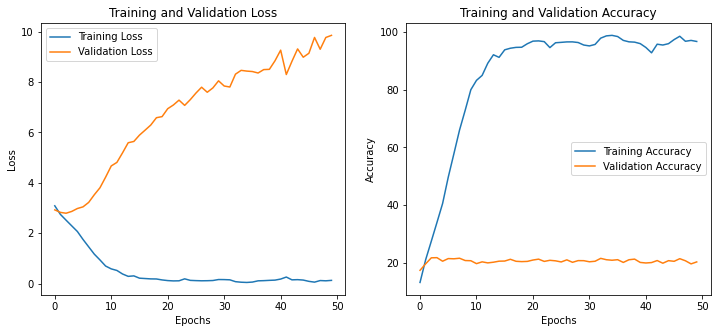

In [68]:
# MLP loss and Accuracy visualization

graph(epoch_n,train_a,train_l,val_a,val_l)


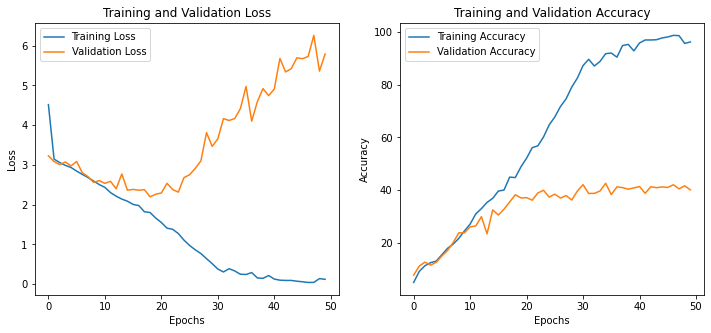

In [16]:
# CNN loss and Accuracy visualization
graph(epo_n,trn_a,trn_l,vl_a,vl_l)


> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

### 2.2 Generating confusion matrix and ROC curves 
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [17]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model,iterator):
    label = []
    pred = []
    

    model.eval()

    with torch.no_grad():
        for x,y in iterator:
            y_pred = model(x)
            predictions = torch.argmax(y_pred, dim=1)

            pred.extend(predictions.numpy().tolist())
            label.extend(y.numpy().tolist())
            
    matrix=confusion_matrix(pred, label)
    return matrix

train_matrix = plot_confusion_matrix(model_cnn, train_loader)
val_matrix = plot_confusion_matrix(model_cnn, val_loader)
    





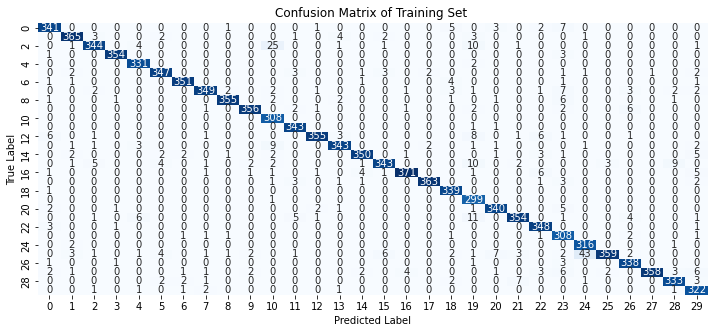

In [18]:
#Confusion matrix of Training dataset
plt.figure(figsize=(12, 5))
sns.heatmap(train_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix of Training Set ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

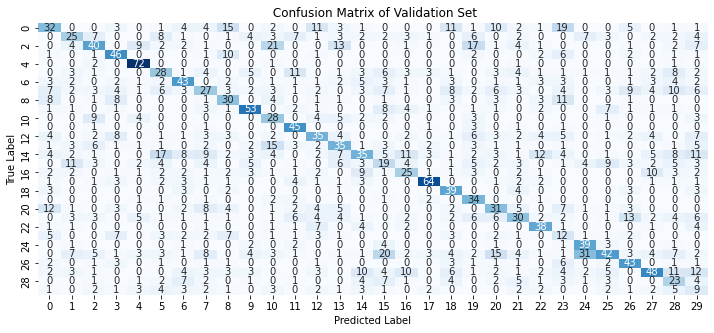

In [19]:
#Confusion matrix of validation dataset
plt.figure(figsize=(12, 5))
sns.heatmap(val_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title(" Confusion Matrix of Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
#ROC

### 2.3 Strategies for tackling overfitting
Using the(final) CNN model perform the strategies below to avoid overfitting problems. We can resuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

In [25]:
train_transforms_agtd = transforms.Compose([
    transforms.RandomRotation(degrees=5),  # Rotate the image randomly by up to 5 degrees
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally
    transforms.RandomVerticalFlip(),  # Flip the image vertically with a probability of 0.5
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),  # crop and resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

#creating augmented dataset
train_data_agtd = ImageFolder(root="./train_set", transform=train_transforms_agtd)

#Splitting augmented dataset to get training set and validation set
torch.manual_seed(0)
total_size = len(train_data_agtd)
val_size = int(0.2 * total_size)
train_size = total_size - val_size
train_dataset_agtd, val_dataset_agtd = random_split(train_data_agtd, [train_size, val_size])

#Creating dataloader
train_loader_agtd = DataLoader(train_dataset_agtd, batch_size=256, shuffle=True)
val_loader_agtd = DataLoader(val_dataset_agtd, batch_size=256, shuffle=False)

#mode="Data augmented"
epo_n_agtd=[]
trn_a_agtd=[]
vl_a_agtd=[]
trn_l_agtd=[]
vl_l_agtd=[]
cnn(train_loader_agtd,val_loader_agtd)




  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 54s
	Train_Loss: 3.2960 | Train_Acc: 8.451%
	 Val_Loss: 3.2158 |  Val_Acc: 7.628%
Epoch: 02 | Epoch Time: 0m 39s
	Train_Loss: 3.0732 | Train_Acc: 12.306%
	 Val_Loss: 2.9968 |  Val_Acc: 13.923%
Epoch: 03 | Epoch Time: 0m 39s
	Train_Loss: 2.9154 | Train_Acc: 16.385%
	 Val_Loss: 2.9087 |  Val_Acc: 16.456%
Epoch: 04 | Epoch Time: 0m 39s
	Train_Loss: 2.8164 | Train_Acc: 18.898%
	 Val_Loss: 3.1436 |  Val_Acc: 15.917%
Epoch: 05 | Epoch Time: 0m 39s
	Train_Loss: 2.7587 | Train_Acc: 19.816%
	 Val_Loss: 3.0495 |  Val_Acc: 17.917%
Epoch: 06 | Epoch Time: 0m 40s
	Train_Loss: 2.7031 | Train_Acc: 22.284%
	 Val_Loss: 3.4637 |  Val_Acc: 12.698%
Epoch: 07 | Epoch Time: 0m 40s
	Train_Loss: 2.6768 | Train_Acc: 21.981%
	 Val_Loss: 3.3884 |  Val_Acc: 14.130%
Epoch: 08 | Epoch Time: 0m 40s
	Train_Loss: 2.6313 | Train_Acc: 23.471%
	 Val_Loss: 3.0699 |  Val_Acc: 17.332%
Epoch: 09 | Epoch Time: 0m 40s
	Train_Loss: 2.5973 | Train_Acc: 24.373%
	 Val_Loss: 2.9065 |  Val_Acc: 21.373%
Epo

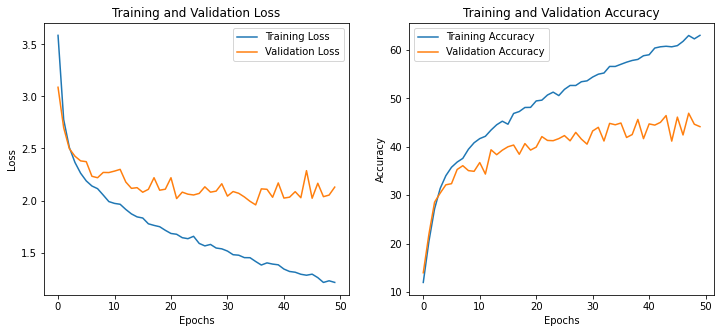

In [21]:
# Visualization of Loss and Accuracy graph using augmented dataset

graph(epo_n_agtd,trn_a_agtd,trn_l_agtd,vl_a_agtd,vl_l_agtd)

#### 2.3.2 Dropout


In [16]:
class TinyImageCNN_dropout(nn.Module):
    def __init__(self):
        super(TinyImageCNN_dropout, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm1= nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.batch_norm2= nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm3= nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm4= nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=250, kernel_size=3, padding=1)
        self.batch_norm5= nn.BatchNorm2d(250)
       # self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
       # self.batch_norm6= nn.BatchNorm2d(512)
        
        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(250*4*4 , 1000)  # Adjusted for 64x64 input image size
        self.fc2 = nn.Linear(1000, 30) 
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max-pooling
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.dropout(x)
        #x = self.pool(F.relu(self.batch_norm5(self.conv5(x))))
        x = F.relu(self.batch_norm5(self.conv5(x)))
        #x = F.relu(self.batch_norm6(self.conv6(x)))
        
        #Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
        
model_cnn = TinyImageCNN_dropout()

#loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)



In [25]:
#training and evaluating dataset after applying dropoutF
e_drop=[]
tracc_drop=[]
trloss_drop=[]
vacc_drop=[]
vloss_drop=[]
cnn(train_loader_agtd,val_loader_agtd)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 42s
	Train_Loss: 3.3069 | Train_Acc: 7.319%
	 Val_Loss: 3.4747 |  Val_Acc: 4.740%
Epoch: 02 | Epoch Time: 0m 39s
	Train_Loss: 3.0590 | Train_Acc: 13.481%
	 Val_Loss: 2.9506 |  Val_Acc: 15.823%
Epoch: 03 | Epoch Time: 0m 40s
	Train_Loss: 2.9084 | Train_Acc: 16.761%
	 Val_Loss: 2.9773 |  Val_Acc: 15.214%
Epoch: 04 | Epoch Time: 0m 40s
	Train_Loss: 2.8122 | Train_Acc: 18.898%
	 Val_Loss: 3.1563 |  Val_Acc: 14.143%
Epoch: 05 | Epoch Time: 0m 40s
	Train_Loss: 2.7442 | Train_Acc: 21.024%
	 Val_Loss: 2.9882 |  Val_Acc: 17.248%
Epoch: 06 | Epoch Time: 0m 39s
	Train_Loss: 2.6841 | Train_Acc: 22.072%
	 Val_Loss: 3.1289 |  Val_Acc: 16.136%
Epoch: 07 | Epoch Time: 0m 40s
	Train_Loss: 2.6401 | Train_Acc: 23.113%
	 Val_Loss: 3.0110 |  Val_Acc: 18.177%
Epoch: 08 | Epoch Time: 0m 40s
	Train_Loss: 2.5998 | Train_Acc: 24.301%
	 Val_Loss: 2.9907 |  Val_Acc: 16.581%
Epoch: 09 | Epoch Time: 0m 40s
	Train_Loss: 2.5691 | Train_Acc: 25.375%
	 Val_Loss: 3.1257 |  Val_Acc: 18.142%
Epo

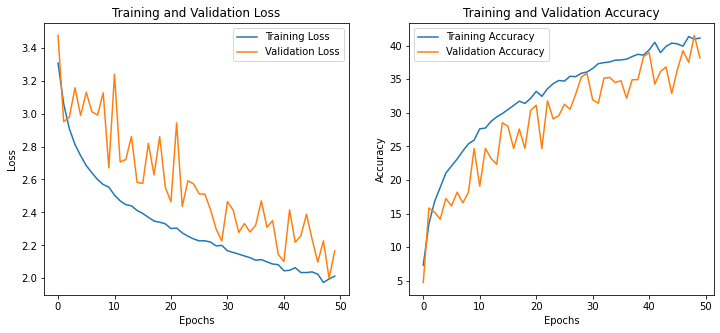

In [26]:
#visualization of Training and accuarcy after applying dropout

graph(e_drop,tracc_drop,trloss_drop,vacc_drop,vloss_drop)

# 2.3.3 Hyperparameter tuning 

> Use learning rates [0.1, 0.001, 0.0001].


In [21]:
train_loss_1=[]
train_loss_2=[]
train_loss_3=[]
val_loss_1=[]
val_loss_2=[]
val_loss_3=[]
train_acc_1=[]
train_acc_2=[]
train_acc_3=[]
val_acc_1=[]
val_acc_2=[]
val_acc_3=[]
epoch_1=[]
epoch_2=[]
epoch_3=[]

In [22]:

def learningrates(lr):
    model_cnn = TinyImageCNN_dropout()
    optimizer = optim.Adam(model_cnn.parameters(), lr)
   
    print("For learning rate =",lr)
    cnn(train_loader_agtd,val_loader_agtd)
  
       
    
    

In [63]:
def graph_for_lr(ep_1,ep_2,ep_3,tr_a1,tr_a2,tr_a3,tr_l1,tr_l2,tr_l3,v_a1,v_a2,v_a3,v_l1,v_l2,v_l3):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Training and Validation Loss for different learning rates")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(ep_1,tr_l1,label="Training Loss for lr 0.1 ")
    plt.plot(ep_1,v_l1,label="Validation Loss for 0.1")
    
    plt.plot(ep_2,tr_l2,label="Training Loss for lr 0.001 ")
    plt.plot(ep_2,v_l2,label="Validation Loss for 0.001")
    
    plt.plot(ep_3,tr_l3,label="Training Loss for lr 0.0001 ")
    #plt.plot(ep_3,v_l3,label="Validation Loss for 0.0001")
    
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Training and Validation Accuracy for different learning rates")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(ep_1,tr_a1,label="Training Accuracy for lr 0.1")
    plt.plot(ep_1,v_a1,label="Validation Accuracy for lr 0.1")
    
    plt.plot(ep_2,tr_a2,label="Training Accuracy for lr 0.001")
    plt.plot(ep_2,v_a2,label="Validation Accuracy for lr 0.001")
    
    plt.plot(ep_3,tr_a3,label="Training Accuracy for lr 0.0001")
    #plt.plot(ep_3,v_a3,label="Validation Accuracy for lr 0.0001")
    
    
    plt.legend()
    plt.show()

In [26]:
e_drop=[]
tracc_drop=[]
trloss_drop=[]
vacc_drop=[]
vloss_drop=[]

learningrates(0.1)

train_loss_1=trloss_drop
val_loss_1=vloss_drop
train_acc_1=tracc_drop
val_acc_1=vacc_drop
epoch_1= e_drop




For learning rate = 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 33s
	Train_Loss: 1.9879 | Train_Acc: 41.252%
	 Val_Loss: 2.2709 |  Val_Acc: 37.202%
Epoch: 02 | Epoch Time: 0m 33s
	Train_Loss: 1.9737 | Train_Acc: 42.490%
	 Val_Loss: 2.1147 |  Val_Acc: 40.377%
Epoch: 03 | Epoch Time: 0m 33s
	Train_Loss: 1.9602 | Train_Acc: 41.915%
	 Val_Loss: 2.0778 |  Val_Acc: 41.379%
Epoch: 04 | Epoch Time: 0m 33s
	Train_Loss: 1.9564 | Train_Acc: 42.188%
	 Val_Loss: 2.1706 |  Val_Acc: 37.970%
Epoch: 05 | Epoch Time: 0m 33s
	Train_Loss: 1.9463 | Train_Acc: 42.857%
	 Val_Loss: 2.2950 |  Val_Acc: 35.692%
Epoch: 06 | Epoch Time: 0m 33s
	Train_Loss: 1.9417 | Train_Acc: 42.508%
	 Val_Loss: 2.2016 |  Val_Acc: 39.148%
Epoch: 07 | Epoch Time: 0m 33s
	Train_Loss: 1.9335 | Train_Acc: 42.463%
	 Val_Loss: 2.0562 |  Val_Acc: 42.526%
Epoch: 08 | Epoch Time: 0m 33s
	Train_Loss: 1.9169 | Train_Acc: 43.253%
	 Val_Loss: 2.0176 |  Val_Acc: 41.952%
Epoch: 09 | Epoch Time: 0m 33s
	Train_Loss: 1.9072 | Train_Acc: 43.496%
	 Val_Loss: 2.2898 |  Val_Acc: 38.047%
E

In [30]:
e_drop=[]
tracc_drop=[]
trloss_drop=[]
vacc_drop=[]
vloss_drop=[]

learningrates(0.001)

train_loss_2=trloss_drop
val_loss_2=vloss_drop
train_acc_2=tracc_drop
val_acc_2=vacc_drop
epoch_2= e_drop


For learning rate = 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 33s
	Train_Loss: 1.6726 | Train_Acc: 49.997%
	 Val_Loss: 1.8978 |  Val_Acc: 46.160%
Epoch: 02 | Epoch Time: 0m 33s
	Train_Loss: 1.6862 | Train_Acc: 49.470%
	 Val_Loss: 1.8602 |  Val_Acc: 46.785%
Epoch: 03 | Epoch Time: 0m 33s
	Train_Loss: 1.6945 | Train_Acc: 49.167%
	 Val_Loss: 1.8801 |  Val_Acc: 45.509%
Epoch: 04 | Epoch Time: 0m 33s
	Train_Loss: 1.6701 | Train_Acc: 50.291%
	 Val_Loss: 1.9719 |  Val_Acc: 44.977%
Epoch: 05 | Epoch Time: 0m 33s
	Train_Loss: 1.6971 | Train_Acc: 48.986%
	 Val_Loss: 1.9872 |  Val_Acc: 44.603%
Epoch: 06 | Epoch Time: 0m 33s
	Train_Loss: 1.6723 | Train_Acc: 49.297%
	 Val_Loss: 2.0072 |  Val_Acc: 44.000%
Epoch: 07 | Epoch Time: 0m 33s
	Train_Loss: 1.6690 | Train_Acc: 50.369%
	 Val_Loss: 1.9171 |  Val_Acc: 46.089%
Epoch: 08 | Epoch Time: 0m 33s
	Train_Loss: 1.6817 | Train_Acc: 49.955%
	 Val_Loss: 1.8334 |  Val_Acc: 47.397%
Epoch: 09 | Epoch Time: 0m 33s
	Train_Loss: 1.6879 | Train_Acc: 49.582%
	 Val_Loss: 1.8142 |  Val_Acc: 47.538%
E

In [31]:
e_drop=[]
tracc_drop=[]
trloss_drop=[]
vacc_drop=vloss_drop=[]

learningrates(0.0001)

train_loss_3=trloss_drop
val_loss_3=vloss_drop
train_acc_3=tracc_drop
val_acc_3=vacc_drop
epoch_3= e_drop

For learning rate = 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 33s
	Train_Loss: 1.5035 | Train_Acc: 54.497%
	 Val_Loss: 1.7824 |  Val_Acc: 49.662%
Epoch: 02 | Epoch Time: 0m 33s
	Train_Loss: 1.5065 | Train_Acc: 54.321%
	 Val_Loss: 1.7449 |  Val_Acc: 50.218%
Epoch: 03 | Epoch Time: 0m 33s
	Train_Loss: 1.5132 | Train_Acc: 54.345%
	 Val_Loss: 1.6674 |  Val_Acc: 51.532%
Epoch: 04 | Epoch Time: 0m 33s
	Train_Loss: 1.4944 | Train_Acc: 54.639%
	 Val_Loss: 1.8133 |  Val_Acc: 48.821%
Epoch: 05 | Epoch Time: 0m 33s
	Train_Loss: 1.4959 | Train_Acc: 54.376%
	 Val_Loss: 1.8367 |  Val_Acc: 48.485%
Epoch: 06 | Epoch Time: 0m 33s
	Train_Loss: 1.4804 | Train_Acc: 55.199%
	 Val_Loss: 1.7424 |  Val_Acc: 49.756%
Epoch: 07 | Epoch Time: 0m 33s
	Train_Loss: 1.4981 | Train_Acc: 54.984%
	 Val_Loss: 1.7652 |  Val_Acc: 49.574%
Epoch: 08 | Epoch Time: 0m 33s
	Train_Loss: 1.4946 | Train_Acc: 54.397%
	 Val_Loss: 1.7646 |  Val_Acc: 49.627%
Epoch: 09 | Epoch Time: 0m 33s
	Train_Loss: 1.4945 | Train_Acc: 54.854%
	 Val_Loss: 1.7010 |  Val_Acc: 51.255%
E

In [ ]:
vl3=[]

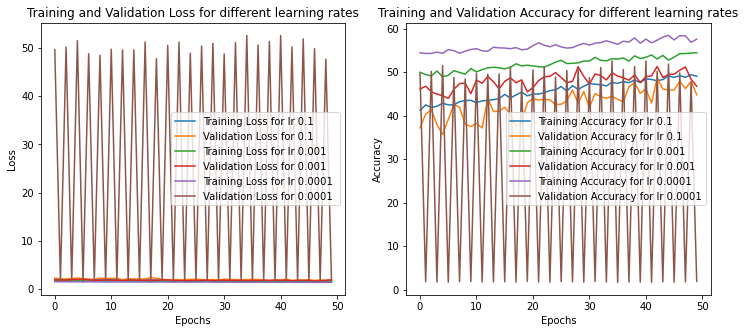

In [62]:

vl3=val_loss_3
trimmed_va3=val_acc_3[:50]
trimmed_vl3 = val_loss_3[:50]
graph_for_lr(epoch_1,epoch_2,epoch_3,train_acc_1,train_acc_2,train_acc_3,train_loss_1,train_loss_2,train_loss_3,val_acc_1,val_acc_2,trimmed_va3,val_loss_1,val_loss_2,trimmed_vl3)

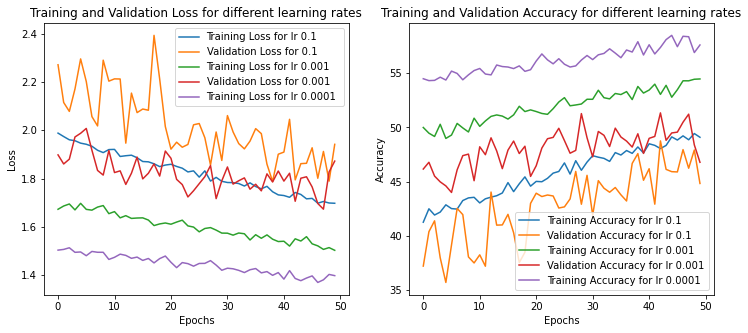

In [64]:
#just to show the graphs by avoiding validation graphs for lr =0.0001
graph_for_lr(epoch_1,epoch_2,epoch_3,train_acc_1,train_acc_2,train_acc_3,train_loss_1,train_loss_2,train_loss_3,val_acc_1,val_acc_2,trimmed_va3,val_loss_1,val_loss_2,trimmed_vl3)

### 3 Model testing 
Online evaluation of your model performance on the test set. 

> Prepare the dataloader for the testset.



#### 3.1 Test class and predictions 

> Build a test class, prepare a test dataloader and generate predictions


In [ ]:

class TinyImage30(Dataset):
    def __init__(self, main_dir, transform=None):
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        self.labels = os.listdir(self.main_dir)
       

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_label = self.labels[idx]
        img_path = os.path.join(self.main_dir,img_label)
        image = torchvision.datasets.folder.default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return img_label,image 
    
test_dataset = TinyImage30(main_dir="./test_set", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
#Upload to kaggle

In [ ]:
import pandas as pd

def predictions(model_cnn, test_loader):
    model_cnn.eval()

    pred_list = []
    file_names = [] 

    with torch.no_grad():
        for file_name,img in test_loader:
            output = model_cnn(img)
            _,predicted= torch.max(output.data, 1)
          
            pred_list.extend(predicted.tolist())
            file_names.extend(file_name)
            
            
    # Create a DataFrame and save to .csv
    Data = {'ID': file_names, 'Category': pred_list}
    preds_df = pd.DataFrame(Data)
    preds_df.to_csv('mm23rnk.csv', index=False)
    
predictions(model_cnn, test_loader)   


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset 

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring the dataset**
   - Download the dataset using ``torchvision.datasets.CIFAR10`` (https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [106]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Download CIFAR-10 dataset and apply transformation
cifar_train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar_test_data = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Splitting into train and validation set
split_ratio = 0.2
n_samples = len(cifar_train_data)
n_validation = int(n_samples * split_ratio)
n_training = n_samples - n_validation

# Split dataset into training and validation sets
cifar_train_set, cifar_val_set = random_split(cifar_train_data, [n_training, n_validation])

cifar_train_loader = DataLoader(cifar_train_set, batch_size=64, shuffle=True,generator=torch.Generator().manual_seed(0))
cifar_val_loader = DataLoader(cifar_val_set, batch_size=64, shuffle=False)




Files already downloaded and verified
Files already downloaded and verified


In [62]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [107]:
import torchvision
import torch
from torchvision import datasets, transforms
from torchsummary import summary

alexnet_model1 = torchvision.models.alexnet(pretrained=True)
alexnet_model2 = torchvision.models.alexnet(pretrained=True)

# Modiy classifier for CIFAR-10
alexnet_model1.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_features = alexnet_model1.classifier[6].in_features
alexnet_model1.classifier[6] = nn.Linear(num_features, 10)



summary(alexnet_model1, input_size=(3, 64, 64))

D:\Software\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

#### 4.1 Apply transfer learning with pretrained model weights


> Configuration 1: No frozen layers

In [12]:
# Your model changes here - also print trainable parameters
import torch.optim as optim
cifar_epoch=[]
cifar_train_accuracy = []
cifar_val_accuracy = []

cifar_train_loss = []
cifar_val_loss = []

def cnn_cifar(train_loader,val_loader,cifar_model):
        epochs= 25
        best_val_loss = float('inf')
        
        for epoch in trange(epochs):
    
            start = time.monotonic()
            epoch_loss1 = 0
            epoch_acc1 = 0
            epoch_loss2 = 0
            epoch_acc2 = 0
    
            cifar_model.train()
            for batch_num, batch_data in enumerate(train_loader, 0):
                    x1, y1 = batch_data
                    x1 = x1.to(device)
                    y1 = y1.to(device)

                    cifar_optimizer.zero_grad() # Clear the gradients

                    y_pred1 = cifar_model(x1)
                    loss1 = cifar_criterion(y_pred1, y1) #Finding loss
                    acc1 = topk_accuracy(y_pred1, y1) #finding accuarcy
                    loss1.backward()  #calcukating gradients
                    cifar_optimizer.step() #Updating weights

                    epoch_loss1 += loss1.item()
                    accuracy1 = torch.tensor(acc1)
                    epoch_acc1 += accuracy1.item()
            train_loss, train_acc = epoch_loss1 / len(train_loader), epoch_acc1 / len(train_loader)

# putting the model in evaluating mode

            cifar_model.eval()
            with torch.no_grad():

                 for  batch_num, batch_data in enumerate(val_loader, 0):
                        x2, y2 = batch_data
                        x2 = x2.to(device)
                        y2 = y2.to(device)

                        y_pred2 = cifar_model(x2)

                        loss2 = cifar_criterion(y_pred2, y2)

                        acc2 = topk_accuracy(y_pred2, y2)

                        epoch_loss2 += loss2.item()
                        accuracy2 = torch.tensor(acc2)
 
                        epoch_acc2 += accuracy2.item()

            val_loss, val_acc=epoch_loss2 / len(val_loader), epoch_acc2 / len(val_loader)

            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(cifar_model.state_dict(), 'tut1-model.pt')

            end = time.monotonic()

            epoch_mins, epoch_seconds = epoch_time(start, end)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_seconds}s')
            print(f'\tTrain_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.3f}%')
            print(f'\t Val_Loss: {val_loss:.4f} |  Val_Acc: {val_acc:.3f}%')
            
            cifar_epoch.append(epoch)
          
            cifar_train_accuracy.append(train_acc)
            cifar_val_accuracy.append(val_acc)

            cifar_train_loss.append(train_loss)
            cifar_val_loss.append(val_loss)
            
  
cifar_criterion = nn.CrossEntropyLoss()
cifar_optimizer = optim.Adam(alexnet_model1.parameters(),lr=0.001)
cnn_cifar(cifar_train_loader,cifar_val_loader,alexnet_model1)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 6m 48s
	Train_Loss: 1.8234 | Train_Acc: 31.203%
	 Val_Loss: 1.5360 |  Val_Acc: 42.387%
Epoch: 02 | Epoch Time: 6m 47s
	Train_Loss: 1.3857 | Train_Acc: 49.950%
	 Val_Loss: 1.2129 |  Val_Acc: 56.081%
Epoch: 03 | Epoch Time: 6m 52s
	Train_Loss: 1.1507 | Train_Acc: 59.020%
	 Val_Loss: 1.0478 |  Val_Acc: 62.988%
Epoch: 04 | Epoch Time: 6m 47s
	Train_Loss: 1.0098 | Train_Acc: 64.483%
	 Val_Loss: 0.9516 |  Val_Acc: 66.650%
Epoch: 05 | Epoch Time: 6m 48s
	Train_Loss: 0.9035 | Train_Acc: 68.438%
	 Val_Loss: 0.9579 |  Val_Acc: 66.610%
Epoch: 06 | Epoch Time: 6m 47s
	Train_Loss: 0.8184 | Train_Acc: 71.653%
	 Val_Loss: 0.8582 |  Val_Acc: 70.890%
Epoch: 07 | Epoch Time: 6m 46s
	Train_Loss: 0.7496 | Train_Acc: 74.150%
	 Val_Loss: 0.8641 |  Val_Acc: 70.790%
Epoch: 08 | Epoch Time: 6m 45s
	Train_Loss: 0.6843 | Train_Acc: 76.448%
	 Val_Loss: 0.8453 |  Val_Acc: 72.781%
Epoch: 09 | Epoch Time: 7m 55s
	Train_Loss: 0.6233 | Train_Acc: 78.740%
	 Val_Loss: 0.8493 |  Val_Acc: 71.915%
E

In [108]:
#testing - delete later

# Your model changes here - also print trainable parameters
import torch.optim as optim
cifar_epoch=[]
cifar_train_accuracy = []
cifar_val_accuracy = []

cifar_train_loss = []
cifar_val_loss = []

def cnn_cifar(train_loader,val_loader,cifar_model):
        epochs= 9
        best_val_loss = float('inf')
        
        for epoch in trange(epochs):
    
            start = time.monotonic()
            epoch_loss1 = 0
            epoch_acc1 = 0
            epoch_loss2 = 0
            epoch_acc2 = 0
    
            cifar_model.train()
            for batch_num, batch_data in enumerate(train_loader, 0):
                    x1, y1 = batch_data
                    x1 = x1.to(device)
                    y1 = y1.to(device)

                    cifar_optimizer.zero_grad() # Clear the gradients

                    y_pred1 = cifar_model(x1)
                    loss1 = cifar_criterion(y_pred1, y1) #Finding loss
                    acc1 = topk_accuracy(y_pred1, y1) #finding accuarcy
                    loss1.backward()  #calcukating gradients
                    cifar_optimizer.step() #Updating weights

                    epoch_loss1 += loss1.item()
                    accuracy1 = torch.tensor(acc1)
                    epoch_acc1 += accuracy1.item()
            train_loss, train_acc = epoch_loss1 / len(train_loader), epoch_acc1 / len(train_loader)

# putting the model in evaluating mode

            cifar_model.eval()
            with torch.no_grad():

                 for  batch_num, batch_data in enumerate(val_loader, 0):
                        x2, y2 = batch_data
                        x2 = x2.to(device)
                        y2 = y2.to(device)

                        y_pred2 = cifar_model(x2)

                        loss2 = cifar_criterion(y_pred2, y2)

                        acc2 = topk_accuracy(y_pred2, y2)

                        epoch_loss2 += loss2.item()
                        accuracy2 = torch.tensor(acc2)
 
                        epoch_acc2 += accuracy2.item()

            val_loss, val_acc=epoch_loss2 / len(val_loader), epoch_acc2 / len(val_loader)

            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(cifar_model.state_dict(), 'tut1-model.pt')

            end = time.monotonic()

            epoch_mins, epoch_seconds = epoch_time(start, end)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_seconds}s')
            print(f'\tTrain_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.3f}%')
            print(f'\t Val_Loss: {val_loss:.4f} |  Val_Acc: {val_acc:.3f}%')
            
            cifar_epoch.append(epoch)
          
            cifar_train_accuracy.append(train_acc)
            cifar_val_accuracy.append(val_acc)

            cifar_train_loss.append(train_loss)
            cifar_val_loss.append(val_loss)
            
  
cifar_criterion = nn.CrossEntropyLoss()
cifar_optimizer = optim.Adam(alexnet_model1.parameters(),lr=0.001)
cnn_cifar(cifar_train_loader,cifar_val_loader,alexnet_model1)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 6m 31s
	Train_Loss: 1.6706 | Train_Acc: 37.583%
	 Val_Loss: 1.4199 |  Val_Acc: 48.995%
Epoch: 02 | Epoch Time: 6m 32s
	Train_Loss: 1.3133 | Train_Acc: 52.250%
	 Val_Loss: 1.1572 |  Val_Acc: 58.360%
Epoch: 03 | Epoch Time: 6m 33s
	Train_Loss: 1.1162 | Train_Acc: 60.453%
	 Val_Loss: 1.0377 |  Val_Acc: 63.008%
Epoch: 04 | Epoch Time: 6m 39s
	Train_Loss: 0.9834 | Train_Acc: 65.578%
	 Val_Loss: 0.8814 |  Val_Acc: 69.437%
Epoch: 05 | Epoch Time: 6m 39s
	Train_Loss: 0.8750 | Train_Acc: 69.593%
	 Val_Loss: 0.9332 |  Val_Acc: 68.312%
Epoch: 06 | Epoch Time: 6m 38s
	Train_Loss: 0.7949 | Train_Acc: 72.507%
	 Val_Loss: 0.8220 |  Val_Acc: 72.004%
Epoch: 07 | Epoch Time: 6m 38s
	Train_Loss: 0.7229 | Train_Acc: 75.138%
	 Val_Loss: 0.8395 |  Val_Acc: 72.144%


KeyboardInterrupt: 

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [16]:


#Freeze convolutional layers
for parameter in alexnet_model2.features.parameters():
    parameter.requires_grad = False
    
alexnet_model2.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
n_features = alexnet_model2.classifier[6].in_features
alexnet_model2.classifier[6] = nn.Linear(n_features, 10)

cifar_epoch2=[]
cifar_train_accuracy2= []
cifar_val_accuracy2 = []

cifar_train_loss2 = []
cifar_val_loss2 = []

cifar_model = alexnet_model2
def cnn_cifar2(train_loader,val_loader,cifar_model):
        epochs= 25
        best_val_loss = float('inf')
        
        for epoch in trange(epochs):
    
            start = time.monotonic()
            epoch_loss1 = 0
            epoch_acc1 = 0
            epoch_loss2 = 0
            epoch_acc2 = 0
    
            cifar_model.train()
            for batch_num, batch_data in enumerate(train_loader, 0):
                    x1, y1 = batch_data
                    x1 = x1.to(device)
                    y1 = y1.to(device)

                    cifar_optimizer.zero_grad() # Clear the gradients

                    y_pred1 = cifar_model(x1)
                    loss1 = cifar_criterion(y_pred1, y1) #Finding loss
                    acc1 = topk_accuracy(y_pred1, y1) #finding accuarcy
                    loss1.backward()  #calcukating gradients
                    cifar_optimizer.step() #Updating weights

                    epoch_loss1 += loss1.item()
                    accuracy1 = torch.tensor(acc1)
                    epoch_acc1 += accuracy1.item()
            train_loss, train_acc = epoch_loss1 / len(train_loader), epoch_acc1 / len(train_loader)

# putting the model in evaluating mode

            cifar_model.eval()
            with torch.no_grad():

                 for  batch_num, batch_data in enumerate(val_loader, 0):
                        x2, y2 = batch_data
                        x2 = x2.to(device)
                        y2 = y2.to(device)

                        y_pred2 = cifar_model(x2)

                        loss2 = cifar_criterion(y_pred2, y2)

                        acc2 = topk_accuracy(y_pred2, y2)

                        epoch_loss2 += loss2.item()
                        accuracy2 = torch.tensor(acc2)
 
                        epoch_acc2 += accuracy2.item()

            val_loss, val_acc=epoch_loss2 / len(val_loader), epoch_acc2 / len(val_loader)

            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(cifar_model.state_dict(), 'tut1-model.pt')

            end = time.monotonic()

            epoch_mins, epoch_seconds = epoch_time(start, end)

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_seconds}s')
            print(f'\tTrain_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.3f}%')
            print(f'\t Val_Loss: {val_loss:.4f} |  Val_Acc: {val_acc:.3f}%')
            
            cifar_epoch2.append(epoch)
          
            cifar_train_accuracy2.append(train_acc)
            cifar_val_accuracy2.append(val_acc)

            cifar_train_loss2.append(train_loss)
            cifar_val_loss2.append(val_loss)
            
  
cifar_criterion = nn.CrossEntropyLoss()
cifar_optimizer = optim.Adam(alexnet_model2.parameters(),lr=0.001)
cnn_cifar2(cifar_train_loader,cifar_val_loader,alexnet_model2)



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 5m 51s
	Train_Loss: 1.6183 | Train_Acc: 40.545%
	 Val_Loss: 1.3864 |  Val_Acc: 50.259%
Epoch: 02 | Epoch Time: 6m 7s
	Train_Loss: 1.4044 | Train_Acc: 49.125%
	 Val_Loss: 1.2957 |  Val_Acc: 52.538%
Epoch: 03 | Epoch Time: 6m 8s
	Train_Loss: 1.3233 | Train_Acc: 52.050%
	 Val_Loss: 1.1831 |  Val_Acc: 57.564%
Epoch: 04 | Epoch Time: 6m 9s
	Train_Loss: 1.2662 | Train_Acc: 54.610%
	 Val_Loss: 1.1500 |  Val_Acc: 59.475%
Epoch: 05 | Epoch Time: 17m 32s
	Train_Loss: 1.2345 | Train_Acc: 55.947%
	 Val_Loss: 1.1449 |  Val_Acc: 59.106%
Epoch: 06 | Epoch Time: 7m 13s
	Train_Loss: 1.1978 | Train_Acc: 57.273%
	 Val_Loss: 1.1096 |  Val_Acc: 60.490%
Epoch: 07 | Epoch Time: 25m 23s
	Train_Loss: 1.1686 | Train_Acc: 58.307%
	 Val_Loss: 1.1037 |  Val_Acc: 61.296%
Epoch: 08 | Epoch Time: 7m 32s
	Train_Loss: 1.1413 | Train_Acc: 59.685%
	 Val_Loss: 1.0540 |  Val_Acc: 63.147%
Epoch: 09 | Epoch Time: 7m 11s
	Train_Loss: 1.1195 | Train_Acc: 60.303%
	 Val_Loss: 1.0361 |  Val_Acc: 63.744%
Ep

#### 4.3 Comparing above configurations and comment on performances

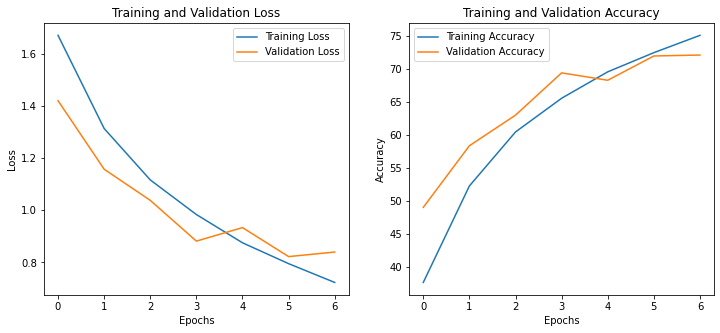

In [111]:


#graph for alexnet model with no frozen layers
graph(cifar_epoch,cifar_train_accuracy,cifar_train_loss,cifar_val_accuracy,cifar_val_loss)

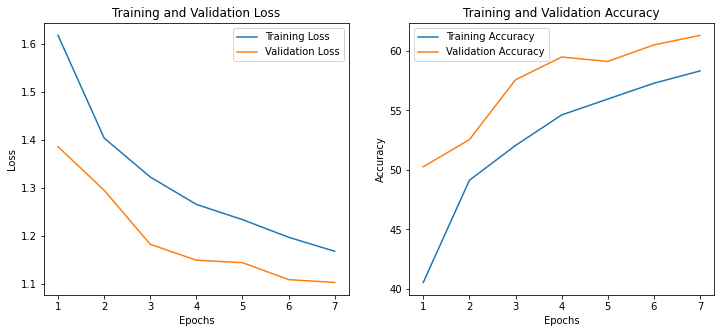

In [132]:
#graph for alexnet model with frozen layers
graph(cifar_epoch2,cifar_train_accuracy2,cifar_train_loss2,cifar_val_accuracy2,cifar_val_loss2)

#comment on performance

The model with no frozen layers seems to have more accuracy than the the one with frozen layers for equal number of epochs. 
But the former model is slightly overfitting but the latter one doesnt have that. So I think the latter one is better and its accuracy can be increased by increasing the epoch.

### Part II: Image Captioning using RNN 



### Objective


> 1. Understand the principles of text pre-processing and vocabulary building 
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.



The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body".  

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary 

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [69]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [74]:
# Load the feature map provided to you
features_map = torch.load('resnet50_caption'+'.pt', map_location=device)

In [ ]:
#### 5 Train DecoderRNN 

> 5.1 Design a RNN-based decoder 

> 5.2 Train your model with precomputed features 

##### 5.1 Design a RNN-based decoder

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [76]:
import json
import pandas as pd

with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [78]:
coco_subset = pd.read_csv("coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

,image_id,id,caption,file_name
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
16758,9,663627,there are containers filled with different kin...,000000000009.jpg
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg


In [85]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
16758,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [86]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:3547, validation:506, test:1015


In [87]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [88]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [89]:
### build vocabulariy for each set - train, val and test 
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2335


In [90]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

2503

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 


In [91]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

D:\Software\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:17<00:00, 5.91MB/s]


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [92]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [93]:
# say this is as below 
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder

In [125]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        # your code
        self.resize = nn.Linear(2048, embed_size)
       
        # batch normalisation helps to speed up training
        # your code
        self.batch_norm = nn.BatchNorm1d(embed_size, momentum = 0.01)

        # your code for embedding layer
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
   
        # your code for RNN
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
   

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_sq_len = max_seq_length
       

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        
    
        embeddings = self.embedding_layer(captions)

        img_features = self.resize(features)
        
        img_features = self.batch_norm(img_features)
       
        # compute your feature embeddings
        # your code
        embedding = self.embedding_layer(captions)
        inputs = torch.cat((img_features.unsqueeze(dim = 1), embedding), dim = 1)
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].
        

        # your code [hint: use pack_padded_sequence]
        pack = pack_padded_sequence(inputs, lengths, batch_first=True)
        output, _ = self.rnn(pack)

        f_output = self.linear(output[0]) #hint: use a hidden layers in parenthesis
        return f_output
   
   
    def sample(self, features, states=None):
        
        """Generate captions for given image features using greedy search."""
        sampled_id = []

        inp = self.batch_norm(self.resize(features)).unsqueeze(1)
        for i in range(self.max_sq_len):
            hidden, states = self.rnn(inp, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hidden.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_id.append(predicted)
            inp = self.embedding_layer(predicted)              # inputs: (batch_size, embed_size)
            inp = inp.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_id = torch.stack(sampled_id, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_id


(25, 2)
Epoch [1/25], Step [0/555], Loss: 7.8606
Epoch [1/25], Step [10/555], Loss: 7.6997
Epoch [1/25], Step [20/555], Loss: 7.5282
Epoch [1/25], Step [30/555], Loss: 7.2339
Epoch [1/25], Step [40/555], Loss: 6.6131
Epoch [1/25], Step [50/555], Loss: 5.9754
Epoch [1/25], Step [60/555], Loss: 5.7351
Epoch [1/25], Step [70/555], Loss: 5.6897
Epoch [1/25], Step [80/555], Loss: 5.4692
Epoch [1/25], Step [90/555], Loss: 5.4870
Epoch [1/25], Step [100/555], Loss: 5.1877
Epoch [1/25], Step [110/555], Loss: 5.4298
Epoch [1/25], Step [120/555], Loss: 5.2867
Epoch [1/25], Step [130/555], Loss: 5.2674
Epoch [1/25], Step [140/555], Loss: 5.4215
Epoch [1/25], Step [150/555], Loss: 5.0867
Epoch [1/25], Step [160/555], Loss: 5.2870
Epoch [1/25], Step [170/555], Loss: 5.1919
Epoch [1/25], Step [180/555], Loss: 5.2843
Epoch [1/25], Step [190/555], Loss: 5.3485
Epoch [1/25], Step [200/555], Loss: 4.9776
Epoch [1/25], Step [210/555], Loss: 5.2465
Epoch [1/25], Step [220/555], Loss: 5.0254
Epoch [1/25], 

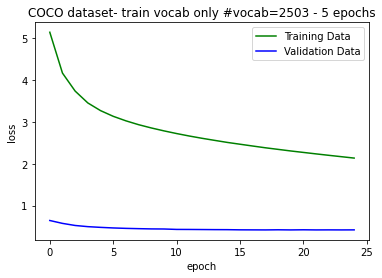

In [127]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

patience = 5
lr = 0.0001

# loss and optimizer here
# your code here --->
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
train_loss = []
val_loss = []
best_value_loss = float('inf')
c = 0
n_epochs = 25

# train the models
total_train_step = len(train_loader)
total_val_step = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0.0
for epoch in range(NUM_EPOCHS):
   
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->
        feature = features_.to(device)
        caption = captions_.to(device)
 
       
        # Reset the gradients
        decoder.zero_grad()
       
        # Forward pass
        output = decoder(feature, caption, lengths_)
       
        # Calculating the loss
        target = pack_padded_sequence(caption, lengths_, batch_first=True)[0]
        loss = criterion(output.view(-1, len(vocab)), target)
       
        # Backward pass and Optimization
        loss.backward()
        optimizer.step()



 
        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_train_step}], Loss: {loss.item():.4f}")
   
    stats[epoch,0] = round(total_loss/total_train_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():  
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->
            feature = features_.to(device)
            caption = captions_.to(device)
       
           
           
            output = decoder(feature, caption, lengths_)
           
            # Calculating the loss
            target = pack_padded_sequence(caption, lengths_, batch_first=True)[0]
            loss = criterion(output.view(-1, len(vocab)), target)
           
            # Forward pass
            total_loss += loss.item()



           
    stats[epoch,1] = round(total_loss/total_train_step,3)
    
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

fig = plt.figure()
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(stats[:,0], 'g', label = 'Training Data', )
plt.plot(stats[:,1], 'b', label = 'Validation Data' )

plt.legend()


fig.savefig("coco_train_vocab_only.png")
plt.show()

In [ ]:
##### 5.2 Training the model with precomputed features 

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [113]:

# loss and optimizer here
# your code here --->
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.1) 

criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 25
# train the models
total_tarin_step = len(train_loader)
total_val_step = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->
        feature = features_.to(device)
        caption = captions_.to(device)

        decoder.zero_grad()

        # Forward pass
        output = decoder(feature, caption, lengths_)

        target_sequence = pack_padded_sequence(caption, lengths_, batch_first=True)[0]
        loss = criterion(output.view(-1, len(vocab)), target_sequence)

        #Backward Pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_train_step}], Loss: {loss.item():.4f}")
    
    stats[epoch,0] = round(total_loss/total_train_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():  
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->
            feature = features_.to(device)
            caption = captions_.to(device)

            output = decoder(feature, caption, lengths_)
            
            target_sequence = pack_padded_sequence(caption, lengths_, batch_first=True)[0]
            loss = criterion(output.view(-1, len(vocab)), target_sequence)

            # Forward pass
            total_loss += loss.item()
            
    stats[epoch,1] = round(total_loss/total_val_step,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()


(25, 2)
Epoch [1/25], Step [0/555], Loss: 39.1755
Epoch [1/25], Step [10/555], Loss: 46.9937
Epoch [1/25], Step [20/555], Loss: 45.3470
Epoch [1/25], Step [30/555], Loss: 45.9156
Epoch [1/25], Step [40/555], Loss: 49.7460
Epoch [1/25], Step [50/555], Loss: 46.3642
Epoch [1/25], Step [60/555], Loss: 47.7242
Epoch [1/25], Step [70/555], Loss: 45.2485
Epoch [1/25], Step [80/555], Loss: 45.8871
Epoch [1/25], Step [90/555], Loss: 38.8023
Epoch [1/25], Step [100/555], Loss: 47.8955
Epoch [1/25], Step [110/555], Loss: 47.4574
Epoch [1/25], Step [120/555], Loss: 45.9830
Epoch [1/25], Step [130/555], Loss: 46.7034
Epoch [1/25], Step [140/555], Loss: 44.3155
Epoch [1/25], Step [150/555], Loss: 51.4936
Epoch [1/25], Step [160/555], Loss: 43.9795
Epoch [1/25], Step [170/555], Loss: 42.0548
Epoch [1/25], Step [180/555], Loss: 46.3910
Epoch [1/25], Step [190/555], Loss: 50.1540
Epoch [1/25], Step [200/555], Loss: 48.2197
Epoch [1/25], Step [210/555], Loss: 45.9647
Epoch [1/25], Step [220/555], Loss:

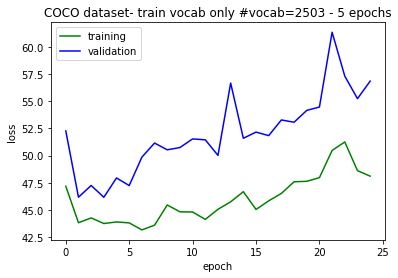

In [114]:
fig = plt.figure()

plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
plt.plot(stats[:,0], 'g', label = 'training', )
plt.plot(stats[:,1], 'b', label = 'validation' )

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

fig.savefig("coco_train_vocab_only2.png")
plt.show()

In [115]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation

#### 6.1 Generate predictions on test data 

Display 4 sample test images containing different objects, along with the model’s generated captions and all the reference captions for each.



In [118]:
class COCOImagesDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe 
        self.transforms = transform
        self.dir = "./coco/images"

    def __getitem__(self,idx):
        path = os.path.join(self.dir, self.dataframe.iloc[idx]['file_name'])
        image = Image.open(path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)
            f = os.path.basename(path)
    
            return image,f

    def __len__(self):
        return len(self.dataframe) 

In [119]:
data_transform = transforms.Compose([ 
    transforms.Resize((224,224)),     
    transforms.ToTensor(),
    #Normalizing using Image Net norms
    transforms.Normalize((0.485, 0.456, 0.406),  
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(test_set,transform=data_transform)

test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=64,shuffle=False,num_workers=0)


In [120]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()


DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embedding_layer): Embedding(2503, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2503, bias=True)
)

In [121]:

# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption


GENERATED: 
 a plate with a sandwich and a fork on it
REFERENCES:
16755    Closeup of bins of food that include broccoli ...
16759    A meal is presented in brightly colored plasti...
16758    there are containers filled with different kin...
16757    Colorful dishes holding meat, vegetables, frui...
16756           A bunch of trays that have different food.
Name: caption, dtype: object



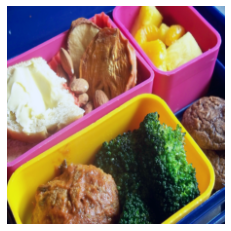

GENERATED: 
 a pair of scissors sitting on a table with a laptop
REFERENCES:
23808    A lot of personal belongings that are in baske...
23809    A couple of basket sitting next to each other ...
23810    A table displays organized items in four baskets.
23811          a desk with stuff for arts and crafts on it
23812    An organized desk with separate baskets for wo...
Name: caption, dtype: object



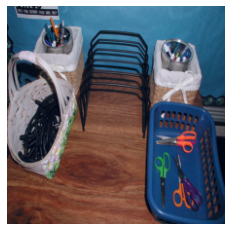

GENERATED: 
 a man eating a hot dog on a bun
REFERENCES:
17617                a person holding a hot dog at a table
17618            A person holds a corn dog in their hands.
17619         A man in a green shirt is holding a hot dog.
17620             A photo of a man eating a large hot dog.
17616    a male in a green and white shirt is holding a...
Name: caption, dtype: object



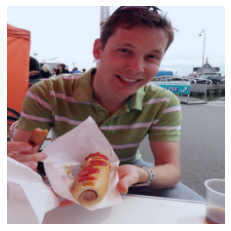

GENERATED: 
 a pair of scissors with <unk> <unk> and <unk>
REFERENCES:
17291    a picture of banana, flavored rolling paper, a...
17292    A pile of ripe bananas sitting on top of a table.
17293    The packaging art of banana flavored rolling p...
17294    A bumch of bananas behind a logo for rolling p...
17295    A picture of a bee is next to a bunch of bananas.
Name: caption, dtype: object



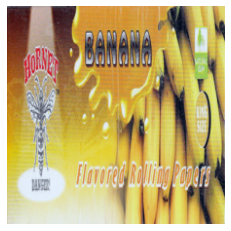

In [128]:
idx = 0
IMAGES_TO_SHOW = 4


uni_names = [] 

with torch.no_grad():
    for i,(image,filename) in enumerate(test_loader):
        
        # your code here --->
        if filename[0] not in uni_names:
            uni_names.append(filename[0])
            input_image = image.to(next(model.parameters()).device)
            feature = model(input_image)
            caption = decoder.sample(feature)
            list_of_captions = [word.item() for word in caption.view(-1)]
            text = decode_caption(list_of_captions,vocab)


        
        print(f"GENERATED: \n {text}")
        print("REFERENCES:")
        ref_loc = test_set['file_name'] == filename[0]
        reference = test_set[ref_loc]['caption']
        print(reference)
        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break
